#Data Pre-processing


In [ ]:
!wget -O images.tar http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget -O annotation.tar http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2020-12-03 18:08:18--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  20.1MB/s    in 41s     

2020-12-03 18:08:58 (18.6 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2020-12-03 18:08:59--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  5.15MB/s    in 4.0s    

2020-12-03 18:09:03 (5.15 MB/s) - ‘annotat

In [ ]:
!tar xf images.tar --totals
!tar xf annotation.tar --totals

Total bytes read: 793579520 (757MiB, 265MiB/s)
Total bytes read: 21852160 (21MiB, 29MiB/s)


In [1]:
import sys
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU
from tensorflow.keras.optimizers import Adam

import torch
from torchvision import datasets, transforms

from tensorflow.keras import backend as K
from keras.engine import *
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils

import numpy as np
from PIL import Image
import json
import os
import time
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import tarfile
import shutil
import math
import glob
import pprint
import re
import xml.etree.ElementTree as ET

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
# run params
image_width = 64
image_height = 64
image_channels = 3
image_channels = 3

SEED_SIZE = 100

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SECTION = 'gan'
RUN_ID = '0006'
DATA_NAME = 'dogs'
DATA_PATH = RUN_ID

EPOCHS = 280

In [ ]:
os.mkdir(DATA_PATH)

In [ ]:
dir_input = "input"
path_img = os.path.join(dir_input, "images")
path_annot = os.path.join(dir_input, "annotations")

In [ ]:
#shutil.rmtree(dir_input)
os.mkdir(dir_input)
os.mkdir(path_img)

In [ ]:
img_filenames = glob.glob("Images/**/*.jpg", recursive=True)
print(len(img_filenames))

20580


In [ ]:
#Copy all the images to the input directory
for name in tqdm(img_filenames):
  shutil.copy(name, path_img)
img_filenames = glob.glob("input/images/*.jpg", recursive=True)
print(img_filenames[1])

100%|██████████| 20580/20580 [00:02<00:00, 7019.25it/s]


input/images/n02097209_743.jpg


In [ ]:
imgs = os.listdir(path_img)
print(len(imgs))
print(imgs[:5])

20580
['n02113186_11017.jpg', 'n02097209_743.jpg', 'n02107574_870.jpg', 'n02096177_1767.jpg', 'n02102318_12613.jpg']


In [ ]:
#Copy all the annotations to the run directory
print("Copying all annotations into one big folder")
shutil.copytree("Annotation", path_annot)

Copying all annotations into one big folder


'input/annotations'

In [ ]:
breeds = glob.glob(path_annot+'/*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed+'/*')
len(annotations)

20580

In [ ]:
breed_map = {}
for annotation in annotations:
  breed = annotation.split('/')[-2]
  index = breed.split('-')[0]
  breed_map.setdefault(index,breed)
n_classes = len(breed_map)
n_classes

120

In [ ]:
pprint.pprint(breed_map)

{'n02085620': 'n02085620-Chihuahua',
 'n02085782': 'n02085782-Japanese_spaniel',
 'n02085936': 'n02085936-Maltese_dog',
 'n02086079': 'n02086079-Pekinese',
 'n02086240': 'n02086240-Shih-Tzu',
 'n02086646': 'n02086646-Blenheim_spaniel',
 'n02086910': 'n02086910-papillon',
 'n02087046': 'n02087046-toy_terrier',
 'n02087394': 'n02087394-Rhodesian_ridgeback',
 'n02088094': 'n02088094-Afghan_hound',
 'n02088238': 'n02088238-basset',
 'n02088364': 'n02088364-beagle',
 'n02088466': 'n02088466-bloodhound',
 'n02088632': 'n02088632-bluetick',
 'n02089078': 'n02089078-black-and-tan_coonhound',
 'n02089867': 'n02089867-Walker_hound',
 'n02089973': 'n02089973-English_foxhound',
 'n02090379': 'n02090379-redbone',
 'n02090622': 'n02090622-borzoi',
 'n02090721': 'n02090721-Irish_wolfhound',
 'n02091032': 'n02091032-Italian_greyhound',
 'n02091134': 'n02091134-whippet',
 'n02091244': 'n02091244-Ibizan_hound',
 'n02091467': 'n02091467-Norwegian_elkhound',
 'n02091635': 'n02091635-otterhound',
 'n020918

In [ ]:
#https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
def bounding_box(img):
    bpath = path_annot + str('/'+breed_map[img.split('_')[0]])+'/'+str(img.split('.')[0])
    tree  = ET.parse(bpath)
    root  = tree.getroot()
    objects = root.findall('object')
    bbxs = []
    for o in objects:
        bndbox = o.find('bndbox') #reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbxs.append((xmin,ymin,xmax,ymax))
    return bbxs

In [ ]:
def bounding_box_ratio(img):
    bpath = path_annot + str('/'+breed_map[img.split('_')[0]])+'/'+str(img.split('.')[0])
    tree  = ET.parse(bpath)
    root  = tree.getroot()
    objects = root.findall('object')
    bbx_ratios = []
    for o in objects:
        bndbox = o.find('bndbox') #reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        xlen = xmax - xmin
        ylen = ymax - ymin
        ratio = ylen / xlen
        bbx_ratios.append((xlen,ylen,ratio))
    return bbx_ratios

In [ ]:
imgs_th = []
ratios_th = []
for img in tqdm(imgs):
  bbx_ratios = bounding_box_ratio(img)
  for i,(xlen,ylen,ratio) in enumerate(bbx_ratios):
      if ((ratio>0.2)&(ratio<4.0)):
          imgs_th.append(img[:-4]+'_'+str(i)+'.jpg')
          ratios_th.append(ratio)
ratios_th = np.array(ratios_th)

print('original : ', len(imgs))
print('after th : ', len(imgs_th))
pprint.pprint(imgs_th[:10])

100%|██████████| 20580/20580 [00:01<00:00, 16634.71it/s]

original :  20580
after th :  22120
['n02113186_11017_0.jpg',
 'n02097209_743_0.jpg',
 'n02107574_870_0.jpg',
 'n02096177_1767_0.jpg',
 'n02102318_12613_0.jpg',
 'n02100877_2741_0.jpg',
 'n02107312_6029_0.jpg',
 'n02088238_9922_0.jpg',
 'n02097298_1152_0.jpg',
 'n02097298_1152_1.jpg']


In [ ]:
#@title Intruders
intruders = [
  #n02088238-basset
  'n02088238_10870_0.jpg',
  
  #n02088466-bloodhound
  'n02088466_6901_1.jpg',
  'n02088466_6963_0.jpg',
  'n02088466_9167_0.jpg',
  'n02088466_9167_1.jpg',
  'n02088466_9167_2.jpg',
  
  #n02089867-Walker_hound
  'n02089867_2221_0.jpg',
  'n02089867_2227_1.jpg',
  
  #n02089973-English_foxhound # No details
  'n02089973_1132_3.jpg',
  'n02089973_1352_3.jpg',
  'n02089973_1458_1.jpg',
  'n02089973_1799_2.jpg',
  'n02089973_2791_3.jpg',
  'n02089973_4055_0.jpg',
  'n02089973_4185_1.jpg',
  'n02089973_4185_2.jpg',
  
  #n02090379-redbone
  'n02090379_4673_1.jpg',
  'n02090379_4875_1.jpg',
  
  #n02090622-borzoi # Confusing
  'n02090622_7705_1.jpg',
  'n02090622_9358_1.jpg',
  'n02090622_9883_1.jpg',
  
  #n02090721-Irish_wolfhound # very small
  'n02090721_209_1.jpg',
  'n02090721_1222_1.jpg',
  'n02090721_1534_1.jpg',
  'n02090721_1835_1.jpg',
  'n02090721_3999_1.jpg',
  'n02090721_4089_1.jpg',
  'n02090721_4276_2.jpg',
  
  #n02091032-Italian_greyhound
  'n02091032_722_1.jpg',
  'n02091032_745_1.jpg',
  'n02091032_1773_0.jpg',
  'n02091032_9592_0.jpg',
  
  #n02091134-whippet
  'n02091134_2349_1.jpg',
  'n02091134_14246_2.jpg',
  
  #n02091244-Ibizan_hound
  'n02091244_583_1.jpg',
  'n02091244_2407_0.jpg',
  'n02091244_3438_1.jpg',
  'n02091244_5639_1.jpg',
  'n02091244_5639_2.jpg',
  
  #n02091467-Norwegian_elkhound
  'n02091467_473_0.jpg',
  'n02091467_4386_1.jpg',
  'n02091467_4427_1.jpg',
  'n02091467_4558_1.jpg',
  'n02091467_4560_1.jpg',
  
  #n02091635-otterhound
  'n02091635_1192_1.jpg',
  'n02091635_4422_0.jpg',
  
  #n02091831-Saluki
  'n02091831_1594_1.jpg',
  'n02091831_2880_0.jpg',
  'n02091831_7237_1.jpg',
  
  #n02092002-Scottish_deerhound
  'n02092002_1551_1.jpg',
  'n02092002_1937_1.jpg',
  'n02092002_4218_0.jpg',
  'n02092002_4596_0.jpg',
  'n02092002_5246_1.jpg',
  'n02092002_6518_0.jpg',
  
  #n02093256-Staffordshire_bullterrier
  'n02093256_1826_1.jpg',
  'n02093256_4997_0.jpg',
  'n02093256_14914_0.jpg',
  
  #n02093428-American_Staffordshire_terrier
  'n02093428_5662_0.jpg',
  'n02093428_6949_1.jpg'
]


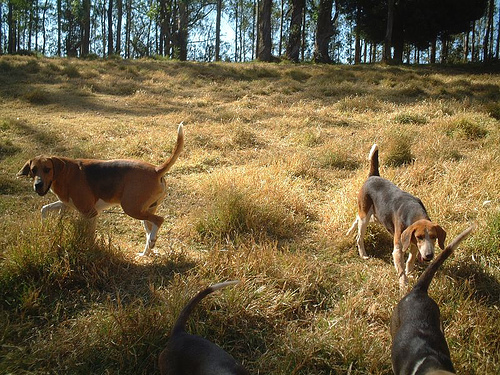

In [ ]:
ind = imgs.index('n02089973_1132.jpg')
Image.open(path_img+'/'+imgs[ind])

In [ ]:
def autocontrast(img, cutoff=1): #cutoff[%]
    if np.random.rand() < 0.5:
        img = ImageOps.autocontrast(img, cutoff)
    return img

def sharpen(img, magnitude=1):
    factor = np.random.uniform(1.0-magnitude, 1.0+magnitude)
    img    = ImageEnhance.Sharpness(img).enhance(factor)
    return img
    
def data_preprocessing(img,bbx_idx):
    bbx = bounding_box(img)[bbx_idx]
    img  = Image.open(os.path.join(path_img, img)).convert('RGB')
    img_cropped  = img.crop(bbx)
    return img_cropped

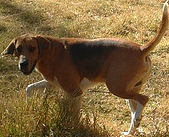

In [ ]:
ind = imgs_th.index('n02089973_1132_1.jpg')
img = data_preprocessing(imgs_th[ind][:-6]+'.jpg',0)
img

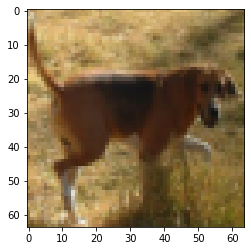

In [ ]:
t1 = transforms.Compose([transforms.Resize([image_width, image_height]),
                         transforms.RandomHorizontalFlip(p=0.5),])
img = t1(img)
plt.imshow(img)
plt.show()

In [ ]:
transformations = transforms.Compose([transforms.Resize([image_width, image_height]),
                                      #transforms.RandomCrop(GENERATE_SQUARE),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      #transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                                      ])
training_data = []
labels = []
for img in tqdm(imgs_th):
  if img in intruders:
    continue
  img_location = img[:-6]+'.jpg'
  bbx_idx = int(img[-5])
  img = data_preprocessing(img_location, bbx_idx)
  img = transformations(img)
  training_data.append(np.asarray(img))
  breed = breed_map[img_location.split('_')[0]]
  label = breed.split('-')[1]
  labels.append(label)
print(len(training_data))

100%|██████████| 22120/22120 [01:19<00:00, 279.84it/s]

22060


(64, 64, 3)


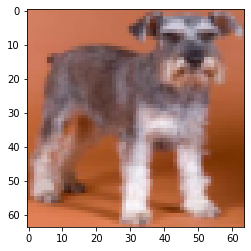

In [ ]:
print(training_data[1].shape)
plt.imshow(training_data[1])
plt.show()

In [ ]:
training_data = np.reshape(training_data,(-1,image_width,image_height,image_channels))
training_data = training_data.astype(np.float32)

In [ ]:
print(training_data[9].shape)

(64, 64, 3)


In [ ]:
print(training_data.shape)

(22060, 64, 64, 3)


In [ ]:
def plot_features(features, labels, image_width=image_width, image_height=image_height, image_channels=image_channels,
examples=25, disp_labels=True): 
  
    if not math.sqrt(examples).is_integer():
        print('Please select a valid number of examples.')
        return
    imgs = []
    classes = []
    for i in range(examples):
        rnd_idx = np.random.randint(0, len(labels))
        imgs.append(features[rnd_idx, :, :, :])
        classes.append(labels[rnd_idx])
    fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)),figsize=(15,15),
    subplot_kw = {'xticks':[], 'yticks':[]},
    gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
    for i, ax in enumerate(axes.flat):
        if disp_labels == True:
            ax.title.set_text(classes[i])
        ax.imshow(imgs[i])

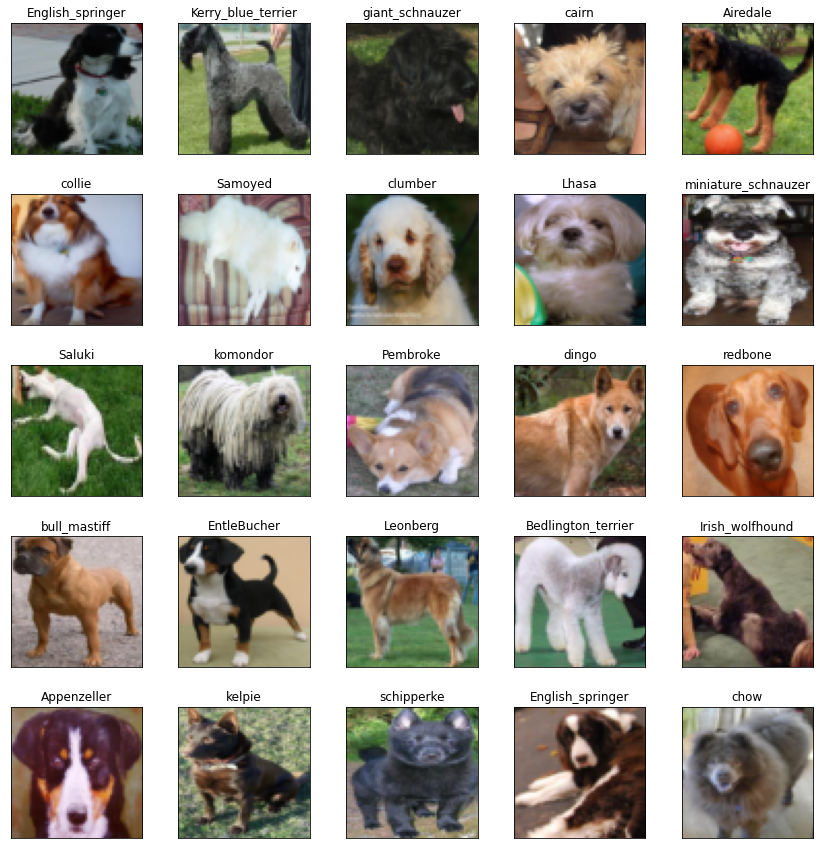

In [ ]:
plot_features(training_data/255., labels, examples=25, disp_labels=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

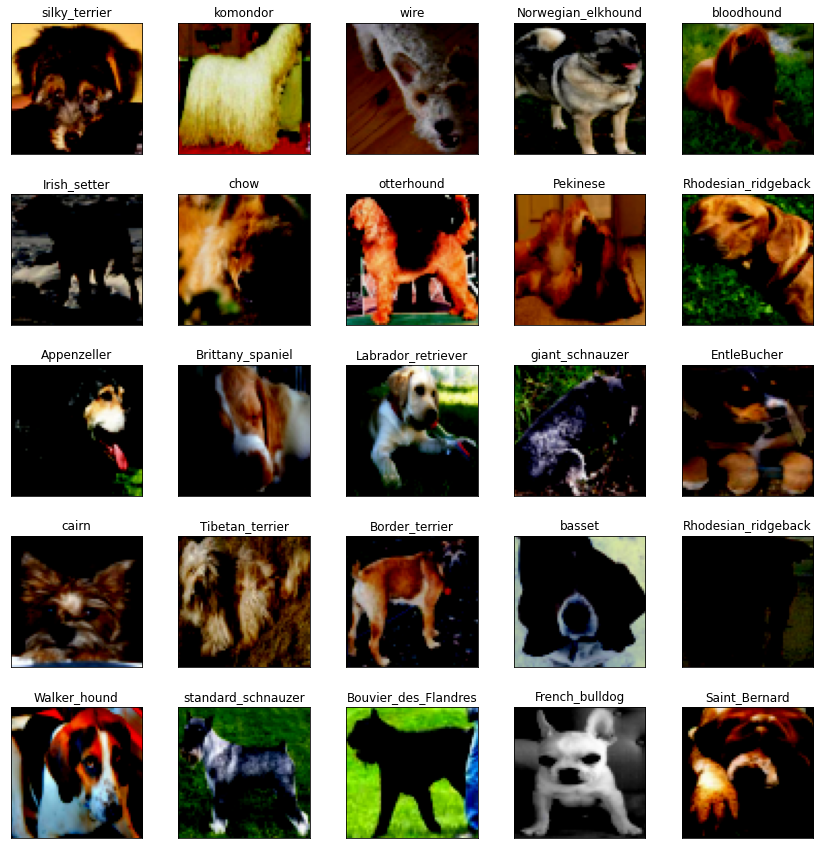

In [ ]:
training_data = (training_data - 127.5) / 127.5
plot_features(training_data, labels, examples=25, disp_labels=True)

In [ ]:
print(np.max(training_data[3,:,:,:]), np.min(training_data[3,:,:,:]))

0.99215686 -0.8352941


#Model

In [2]:
weight_init_std = 0.02
weight_init_mean = 0.0

leaky_relu_slope = 0.2
downsize_factor = 2
scale_factor = 4 ** downsize_factor
dropout_rate = 0.5

batch_size = 128

lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000

noise_dim = 128

In [ ]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=42)

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(22060).batch(batch_size, drop_remainder=True)

In [ ]:
#@title Spectral Normalization
#credit: https://github.com/IShengFang/SpectralNormalizationKeras
class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output
            
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [ ]:
def transposed_conv(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (ksize, ksize),
                              strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def transposed_convSN(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(ConvSN2DTranspose(out_channels, (ksize, ksize), 
                              strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def convSN(model, out_channels, ksize, stride_size):
    model.add(ConvSN2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))
    return model

def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))
    return model

In [ ]:
def build_generator():
    model = Sequential()
    model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128,
                    input_shape=(noise_dim,), kernel_initializer=weight_initializer))
    #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
    #model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 128)))
    
    model = transposed_conv(model, 512, ksize=5, stride_size=1)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 256, ksize=5, stride_size=2)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 128, ksize=5, stride_size=2)
    model = transposed_conv(model, 64, ksize=5, stride_size=2)
    model = transposed_conv(model, 32, ksize=5, stride_size=2)
    
    model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))

    return model

def build_discriminator(spectral_normalization=True):
    model = Sequential()
    if spectral_normalization:
        model.add(ConvSN2D(64, (5, 5), strides=(1,1), padding='same', use_bias=False,
                         input_shape=[image_height, image_width, image_channels], 
                         kernel_initializer=weight_initializer))
        #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
        model.add(LeakyReLU(alpha=leaky_relu_slope))
        #model.add(Dropout(dropout_rate))
        
        model = convSN(model, 64, ksize=5, stride_size=2)
        #model = convSN(model, 128, ksize=3, stride_size=1)
        model = convSN(model, 128, ksize=5, stride_size=2)
        #model = convSN(model, 256, ksize=3, stride_size=1)
        model = convSN(model, 256, ksize=5, stride_size=2)
        #model = convSN(model, 512, ksize=3, stride_size=1)
        #model.add(Dropout(dropout_rate))

        model.add(Flatten())
        model.add(DenseSN(1, activation='sigmoid'))
    else:
        ...
    return model

In [ ]:
generator = build_generator()
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 64, 64, 3)
(1, 128) -0.06688655 0.95536345


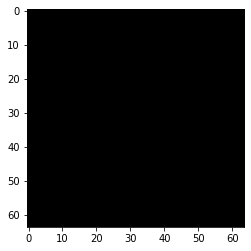

In [ ]:
noise = tf.random.normal([1,noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)
print(noise.shape, tf.math.reduce_mean(noise).numpy(), tf.math.reduce_std(noise).numpy())

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (image_height+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (image_height+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = np.array(generator(noise, training=False))

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (image_height+16) + PREVIEW_MARGIN
        c = col * (image_height+16) + PREVIEW_MARGIN
        image_array[r:r+image_height,c:c+image_height] = ((generated_images[image_count,:,:,:] + 1.) / 2.*255)
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
def generate_image():
  test_input = tf.random.normal([1, noise_dim])
  generated_image = generator(test_input, training=False)[0,:,:,:]
  generated_image = (generated_image * 127.5 + 127.5) / 255.
  plt.imshow(generated_image)
  plt.axis('off')
  plt.show()
  return generated_image

In [ ]:
discriminator = build_discriminator(spectral_normalization=True)
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_s_n2d (ConvSN2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv_s_n2d_1 (ConvSN2D)      (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv_s_n2d_2 (ConvSN2D)      (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)      

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000078]], shape=(1, 1), dtype=float32)


In [ ]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1., y[i]))
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output, loss_func, apply_label_smoothing=True, label_noise=True):
    if label_noise and apply_label_smoothing:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
        real_output_smooth = smooth_positive_labels(real_output_noise)
        fake_output_smooth = smooth_negative_labels(fake_output_noise)
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
    loss = fake_loss + real_loss
    return loss

def generator_loss(real_output, fake_output, loss_func, apply_label_smoothing=True):
    if apply_label_smoothing:
        fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
        if loss_func == 'gan':
            return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)
    return loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_initial_g, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_initial_d, beta_1=0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Train


In [ ]:
def plot_losses(G_losses, D_losses, all_gl, all_dl, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(all_gl)),all_gl,label='G')
    plt.plot(np.arange(len(all_dl)),all_dl,label='D')
    plt.legend()
    #plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
    plt.title('All Time Loss')
    plt.show()

In [ ]:
@tf.function
def train_step(images, loss_type='gan'):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(real_output, fake_output, loss_type, apply_label_smoothing=True)
        disc_loss = discriminator_loss(real_output, fake_output, loss_type, 
                                       apply_label_smoothing=True, label_noise=True)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [ ]:
g_loss_epochs = []
d_loss_epochs = []
seed = tf.random.normal([(PREVIEW_ROWS * PREVIEW_COLS), noise_dim])

In [ ]:
display_results = 40
decay_step = 50
def train(dataset, epochs):
  start = time.time()
  all_gl = np.array([]); all_dl = np.array([])

  for epoch in range(epochs):
    epoch_start = time.time()

    new_lr_d = lr_initial_d
    new_lr_g = lr_initial_g
    global_step = 0

    g_loss = []
    d_loss = []

    for image_batch in dataset:
      t = train_step(image_batch)
      g_loss.append(t[0])
      d_loss.append(t[1])
      global_step = global_step + 1
      all_gl = np.append(all_gl,np.array([g_loss]))
      all_dl = np.append(all_dl,np.array([d_loss]))

    if (epoch + 1) % display_results == 0 or epoch == 0:
      plot_losses(g_loss, d_loss, all_gl, all_dl, epoch + 1)

    if (epoch + 1) % decay_step == 0:
      new_lr_d = tf.compat.v1.train.cosine_decay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
      new_lr_g = tf.compat.v1.train.cosine_decay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
      generator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_d, beta_1=0.5)
      discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_g, beta_1=0.5)    
    
    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss mean={np.mean(g_loss)}, std={np.std(g_loss)} - disc loss mean={np.mean(d_loss)}, std={np.std(d_loss)},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,seed)

  elapsed = hms_string(time.time()-start)

  print ('Training time: '+ elapsed)


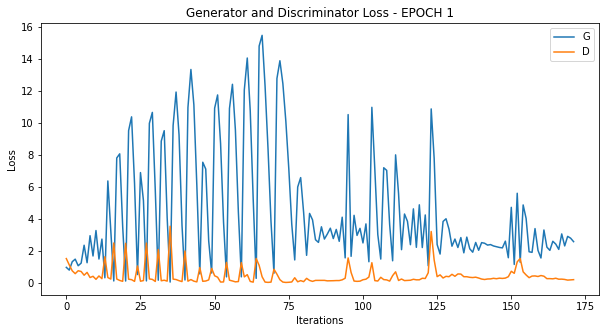

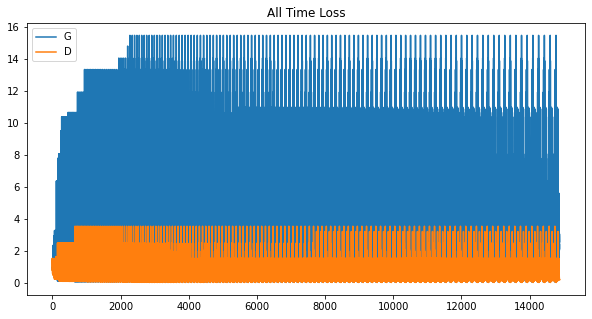

Epoch 1, gen loss mean=4.560274124145508, std=3.7084906101226807 - disc loss mean=0.4388844668865204, std=0.571290135383606, 0:00:34.12
Epoch 2, gen loss mean=3.012845754623413, std=1.5879884958267212 - disc loss mean=0.33887165784835815, std=0.36359283328056335, 0:00:28.57
Epoch 3, gen loss mean=2.8897390365600586, std=2.083998680114746 - disc loss mean=0.5584542751312256, std=0.7941555380821228, 0:00:28.16
Epoch 4, gen loss mean=3.297032117843628, std=1.9844536781311035 - disc loss mean=0.45213672518730164, std=0.3904186189174652, 0:00:28.14
Epoch 5, gen loss mean=3.1130568981170654, std=1.7446810007095337 - disc loss mean=0.4518924057483673, std=0.3187611401081085, 0:00:28.19
Epoch 6, gen loss mean=2.6464385986328125, std=1.3776695728302002 - disc loss mean=0.47536104917526245, std=0.49695703387260437, 0:00:28.17
Epoch 7, gen loss mean=2.6776340007781982, std=1.3531092405319214 - disc loss mean=0.5100851058959961, std=0.27357760071754456, 0:00:28.20
Epoch 8, gen loss mean=2.57298612

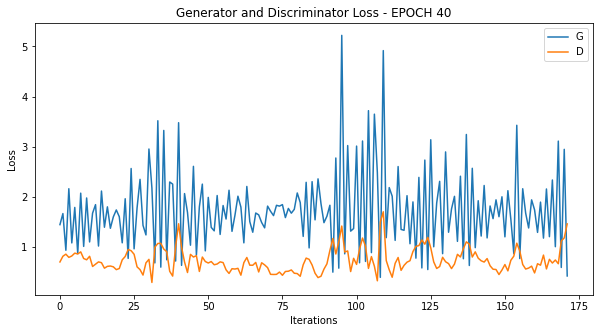

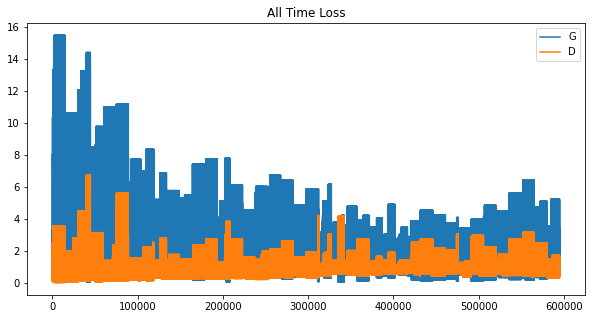

Epoch 40, gen loss mean=1.7393429279327393, std=0.8030233383178711 - disc loss mean=0.7408239841461182, std=0.23386190831661224, 0:00:29.72
Epoch 41, gen loss mean=1.6207704544067383, std=0.6994460821151733 - disc loss mean=0.8141800761222839, std=0.2157725691795349, 0:00:28.60
Epoch 42, gen loss mean=1.544060230255127, std=0.5923206806182861 - disc loss mean=0.7926924824714661, std=0.26908767223358154, 0:00:28.69
Epoch 43, gen loss mean=1.5305044651031494, std=0.6203947067260742 - disc loss mean=0.8519083857536316, std=0.3938823640346527, 0:00:28.64
Epoch 44, gen loss mean=1.4983941316604614, std=0.573718786239624 - disc loss mean=0.8062451481819153, std=0.2621573805809021, 0:00:28.63
Epoch 45, gen loss mean=1.5184276103973389, std=0.6151739358901978 - disc loss mean=0.8412624001502991, std=0.31163489818573, 0:00:28.65
Epoch 46, gen loss mean=1.5426621437072754, std=0.6935160756111145 - disc loss mean=0.8527060151100159, std=0.3948602080345154, 0:00:28.70
Epoch 47, gen loss mean=1.553

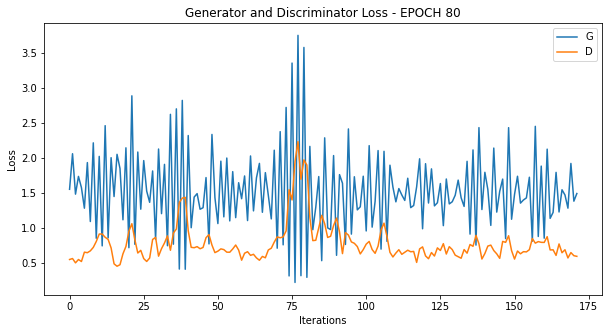

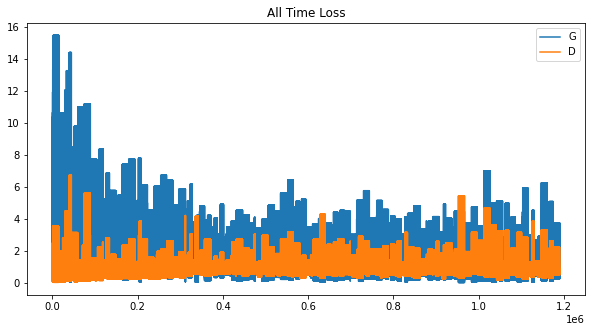

Epoch 80, gen loss mean=1.5238912105560303, std=0.6073205471038818 - disc loss mean=0.7825182676315308, std=0.2732260227203369, 0:00:30.82
Epoch 81, gen loss mean=1.511372447013855, std=0.5309129357337952 - disc loss mean=0.7366482019424438, std=0.18683023750782013, 0:00:29.68
Epoch 82, gen loss mean=1.5880547761917114, std=0.7007277607917786 - disc loss mean=0.7626197338104248, std=0.3745254874229431, 0:00:29.70
Epoch 83, gen loss mean=1.5706428289413452, std=0.5888106226921082 - disc loss mean=0.7239682674407959, std=0.221338152885437, 0:00:29.71
Epoch 84, gen loss mean=1.640565037727356, std=0.7723782062530518 - disc loss mean=0.7922006845474243, std=0.4785759449005127, 0:00:29.74
Epoch 85, gen loss mean=1.5255573987960815, std=0.5772910714149475 - disc loss mean=0.7703067660331726, std=0.3165504038333893, 0:00:29.70
Epoch 86, gen loss mean=1.5381654500961304, std=0.678345799446106 - disc loss mean=0.8493792414665222, std=0.448061466217041, 0:00:29.75
Epoch 87, gen loss mean=1.55069

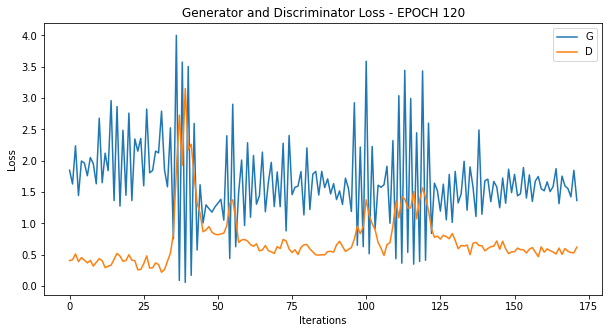

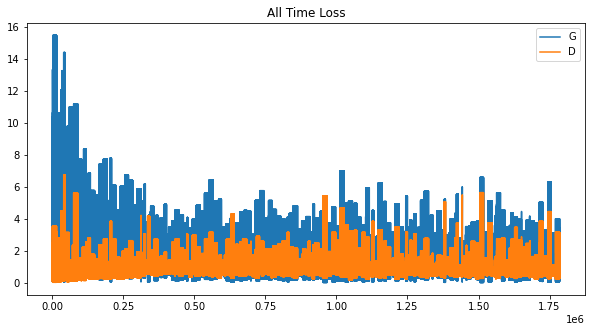

Epoch 120, gen loss mean=1.6777119636535645, std=0.6973244547843933 - disc loss mean=0.7395146489143372, std=0.4263123571872711, 0:00:32.42
Epoch 121, gen loss mean=1.6554157733917236, std=0.4971485137939453 - disc loss mean=0.6040629744529724, std=0.10762152075767517, 0:00:30.19
Epoch 122, gen loss mean=1.6325016021728516, std=0.6297340393066406 - disc loss mean=0.7173390984535217, std=0.36310964822769165, 0:00:30.11
Epoch 123, gen loss mean=1.6754040718078613, std=0.5923616886138916 - disc loss mean=0.6377987265586853, std=0.19909003376960754, 0:00:30.12
Epoch 124, gen loss mean=1.6633511781692505, std=0.677574872970581 - disc loss mean=0.7242611646652222, std=0.36771291494369507, 0:00:30.10
Epoch 125, gen loss mean=1.6474300622940063, std=0.5477311611175537 - disc loss mean=0.6589776873588562, std=0.3332671523094177, 0:00:30.18
Epoch 126, gen loss mean=1.6930859088897705, std=0.6447955369949341 - disc loss mean=0.6867731809616089, std=0.44344258308410645, 0:00:30.20
Epoch 127, gen l

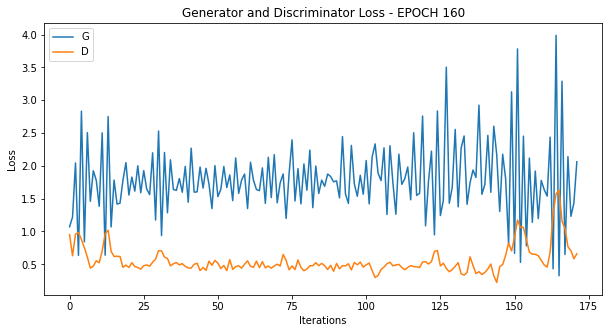

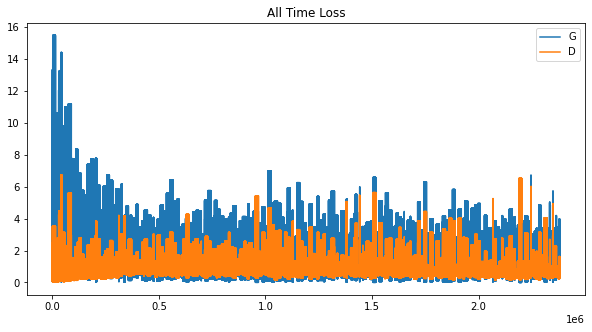

Epoch 160, gen loss mean=1.7861523628234863, std=0.569191575050354 - disc loss mean=0.5586626529693604, std=0.20623180270195007, 0:00:33.32
Epoch 161, gen loss mean=1.6738717555999756, std=0.694196879863739 - disc loss mean=0.749261736869812, std=0.5717406868934631, 0:00:30.52
Epoch 162, gen loss mean=1.7607489824295044, std=0.5731101036071777 - disc loss mean=0.5661715865135193, std=0.1799701303243637, 0:00:30.47
Epoch 163, gen loss mean=1.792696237564087, std=0.8008173704147339 - disc loss mean=0.7309713959693909, std=0.6763101816177368, 0:00:30.48
Epoch 164, gen loss mean=1.5997711420059204, std=0.6055564284324646 - disc loss mean=0.7397884726524353, std=0.35031425952911377, 0:00:30.45
Epoch 165, gen loss mean=1.7590545415878296, std=0.43508684635162354 - disc loss mean=0.5254789590835571, std=0.08825943619012833, 0:00:30.47
Epoch 166, gen loss mean=1.7316784858703613, std=0.679146945476532 - disc loss mean=0.6858441233634949, std=0.5054660439491272, 0:00:30.52
Epoch 167, gen loss m

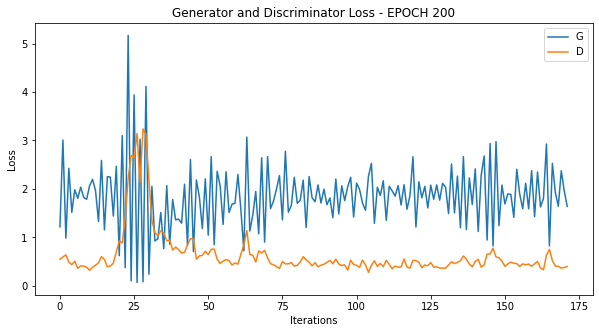

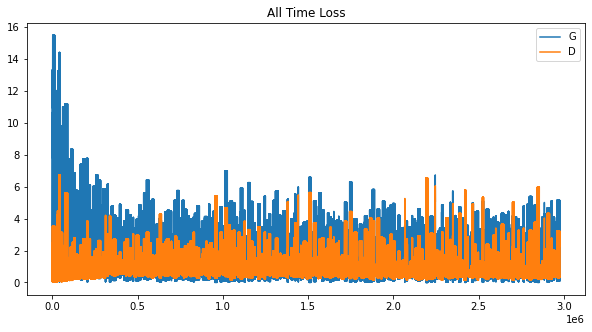

Epoch 200, gen loss mean=1.8374850749969482, std=0.6946516036987305 - disc loss mean=0.6417379379272461, std=0.49610835313796997, 0:00:34.16
Epoch 201, gen loss mean=1.8634668588638306, std=0.7134425044059753 - disc loss mean=0.615830659866333, std=0.42061564326286316, 0:00:31.15
Epoch 202, gen loss mean=1.95000422000885, std=0.5564366579055786 - disc loss mean=0.4760752320289612, std=0.21086351573467255, 0:00:31.10
Epoch 203, gen loss mean=1.9545011520385742, std=0.6959466934204102 - disc loss mean=0.5400450229644775, std=0.31646987795829773, 0:00:31.01
Epoch 204, gen loss mean=1.9535263776779175, std=0.5518602132797241 - disc loss mean=0.4799768328666687, std=0.23723959922790527, 0:00:31.05
Epoch 205, gen loss mean=1.7841752767562866, std=0.7419213652610779 - disc loss mean=0.693932294845581, std=0.4683697819709778, 0:00:31.06
Epoch 206, gen loss mean=1.9346139430999756, std=0.5864619612693787 - disc loss mean=0.5055643916130066, std=0.2849748730659485, 0:00:31.04
Epoch 207, gen loss

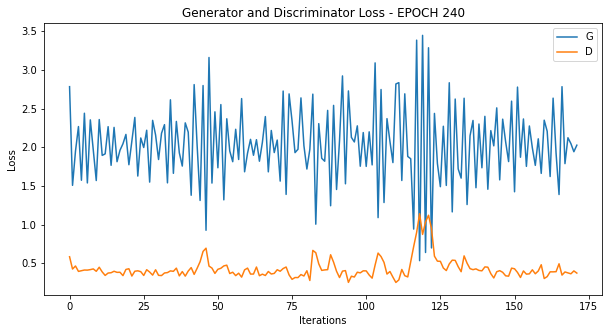

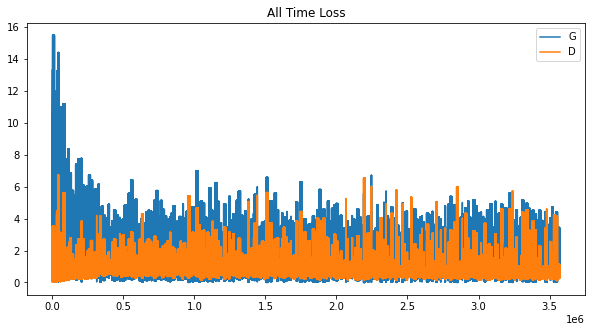

Epoch 240, gen loss mean=2.034682035446167, std=0.511238694190979 - disc loss mean=0.4295402765274048, std=0.13655106723308563, 0:00:35.57
Epoch 241, gen loss mean=2.070890188217163, std=0.5181309580802917 - disc loss mean=0.4024450480937958, std=0.08712481707334518, 0:00:30.59
Epoch 242, gen loss mean=1.9736632108688354, std=0.8041307926177979 - disc loss mean=0.6339145302772522, std=0.533592939376831, 0:00:30.66
Epoch 243, gen loss mean=2.0403835773468018, std=0.46149858832359314 - disc loss mean=0.4062061011791229, std=0.10551373660564423, 0:00:30.76
Epoch 244, gen loss mean=1.985633373260498, std=0.6507079601287842 - disc loss mean=0.5470308661460876, std=0.4410824775695801, 0:00:30.80
Epoch 245, gen loss mean=2.022907257080078, std=0.7367286086082458 - disc loss mean=0.5449472069740295, std=0.38687536120414734, 0:00:30.71
Epoch 246, gen loss mean=2.063724994659424, std=0.6084293127059937 - disc loss mean=0.48495253920555115, std=0.4702973961830139, 0:00:30.69
Epoch 247, gen loss m

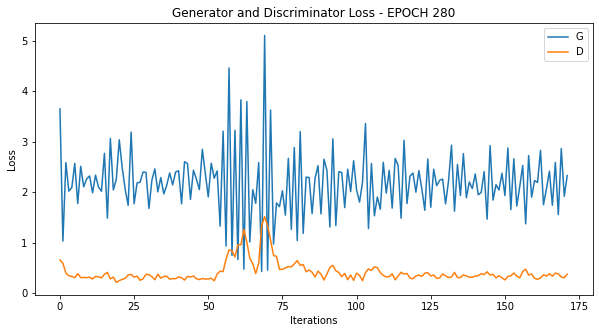

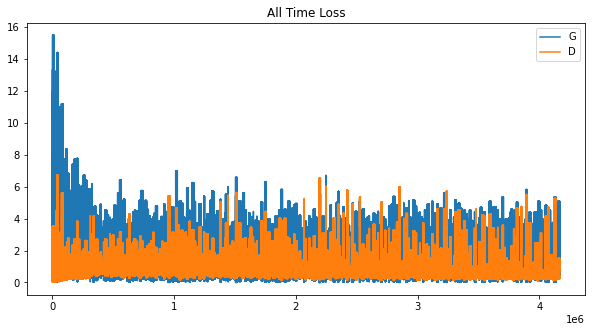

Epoch 280, gen loss mean=2.183063507080078, std=0.6654402017593384 - disc loss mean=0.4145734906196594, std=0.20658066868782043, 0:00:35.27
Training time: 2:20:49.93


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint_dir = os.path.join(DATA_PATH,"training_checkpoints")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix)

'0006/training_checkpoints/ckpt-1'

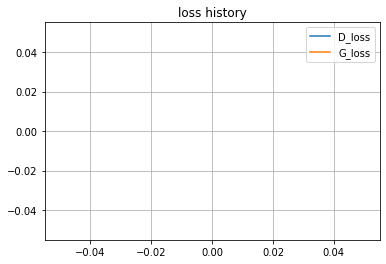

In [ ]:
plt.plot(d_loss_epochs, label='D_loss')
plt.plot(g_loss_epochs, label='G_loss')
plt.grid()
plt.legend()
plt.title('loss history')
plt.savefig(os.path.join(DATA_PATH,"loss_history.png"))
plt.show()

In [ ]:
generator.save(os.path.join(DATA_PATH,"dog_generator.h5"))

In [ ]:
!zip -r {DATA_PATH}\.zip {DATA_PATH}

In [ ]:
from google.colab import files
files.download(DATA_PATH+".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Reload Model

In [3]:
def generate_and_save_image():
  test_input = tf.random.normal([1, noise_dim])
  generated_image = generator(test_input, training=False)[0,:,:,:]
  generated_image = (generated_image * 127.5 + 127.5) / 255.
  plt.imshow(generated_image)
  plt.axis('off')
  plt.show()
  return generated_image

In [ ]:
generator = keras.models.load_model('dog_generator.h5')

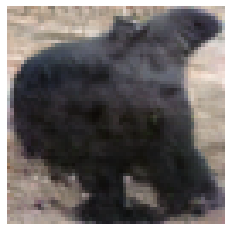

In [27]:
test_img = generate_and_save_image()